# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/tmp/ipykernel_1154043/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_1154043/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_1154043/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_da

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_test)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_test)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [20]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




  0%|          | 3/1000 [00:00<00:35, 27.98it/s]

current_loss: tensor(1.4719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4439, grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:00<00:28, 34.11it/s]

current_loss: tensor(1.4439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4437, grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:00<00:27, 35.18it/s]

current_loss: tensor(1.4437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:00<00:28, 34.25it/s]

current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:01<00:27, 35.03it/s]

current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:01<00:28, 33.65it/s]

current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:01<00:27, 34.41it/s]

current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:01<00:28, 33.44it/s]

current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)


  6%|▋         | 63/1000 [00:01<00:27, 33.52it/s]

current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)


  7%|▋         | 67/1000 [00:01<00:29, 32.02it/s]

current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:02<00:27, 33.83it/s]

current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)


  8%|▊         | 83/1000 [00:02<00:26, 34.12it/s]

current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)


  9%|▉         | 91/1000 [00:02<00:27, 33.06it/s]

current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)


 10%|▉         | 95/1000 [00:02<00:26, 34.33it/s]

current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:02<00:26, 33.86it/s]

current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432,

 10%|█         | 103/1000 [00:03<00:57, 15.58it/s]

current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432,

 10%|█         | 104/1000 [00:03<00:32, 27.42it/s]

current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4432, grad_fn=<MeanBackward0>)
Early Stop at iteration 104 with minimal loss tensor(1.4432, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [ ]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [ ]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [ ]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    #"RW2": {"tau_a": 1e-3, "tau_b": 1e-3},   # A) nearly-flat proper  ← recommended
    "RW2": {"tau_a": 1.1,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}

In [21]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=100,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  2%|▏         | 2/100 [00:00<00:16,  5.90it/s]

[1/100] train=38.2635  val=38.8239  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0510 σmin=0.0510 σmax=0.0510   tau4=0.1995497685 rank=20  E_qf≈0.0896  tau*E[qf]≈0.01787  Δ=+8.95e-02
[2/100] train=37.1692  val=38.3555  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0520 σmin=0.0520 σmax=0.0520   tau4=0.2801445608 rank=20  E_qf≈0.0896  tau*E[qf]≈0.02509  Δ=+8.06e-02


  4%|▍         | 4/100 [00:00<00:15,  6.22it/s]

[3/100] train=39.3866  val=37.8872  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0530 σmin=0.0530 σmax=0.0530   tau4=0.3526798738 rank=20  E_qf≈0.0896  tau*E[qf]≈0.03158  Δ=+7.25e-02
[4/100] train=39.0861  val=37.4191  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0541 σmin=0.0541 σmax=0.0541   tau4=0.4179616555 rank=20  E_qf≈0.0896  tau*E[qf]≈0.03743  Δ=+6.53e-02


  6%|▌         | 6/100 [00:00<00:14,  6.32it/s]

[5/100] train=35.2230  val=36.9519  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0551 σmin=0.0551 σmax=0.0551   tau4=0.476715259 rank=20  E_qf≈0.0896  tau*E[qf]≈0.04269  Δ=+5.88e-02
[6/100] train=34.2072  val=36.4850  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0562 σmin=0.0562 σmax=0.0562   tau4=0.5295935022 rank=20  E_qf≈0.0896  tau*E[qf]≈0.04743  Δ=+5.29e-02


  8%|▊         | 8/100 [00:01<00:14,  6.40it/s]

[7/100] train=36.0011  val=36.0174  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0573 σmin=0.0573 σmax=0.0573   tau4=0.577183921 rank=20  E_qf≈0.0896  tau*E[qf]≈0.05169  Δ=+4.76e-02
[8/100] train=34.6507  val=35.5504  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0584 σmin=0.0584 σmax=0.0584   tau4=0.620015298 rank=20  E_qf≈0.0896  tau*E[qf]≈0.05552  Δ=+4.28e-02


 10%|█         | 10/100 [00:01<00:14,  6.40it/s]

[9/100] train=36.9011  val=35.0837  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0596 σmin=0.0596 σmax=0.0596   tau4=0.6585635373 rank=20  E_qf≈0.0896  tau*E[qf]≈0.05898  Δ=+3.85e-02
[10/100] train=34.3323  val=34.6178  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0607 σmin=0.0607 σmax=0.0607   tau4=0.6932569526 rank=20  E_qf≈0.0896  tau*E[qf]≈0.06208  Δ=+3.47e-02


 11%|█         | 11/100 [00:01<00:15,  5.91it/s]

[11/100] train=36.4623  val=34.1520  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0619 σmin=0.0619 σmax=0.0619   tau4=0.7244810264 rank=20  E_qf≈0.0896  tau*E[qf]≈0.06488  Δ=+3.12e-02
[12/100] train=35.5497  val=33.6859  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0631 σmin=0.0631 σmax=0.0631   tau4=0.7525826929 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0674  Δ=+2.81e-02


 13%|█▎        | 13/100 [00:02<00:16,  5.39it/s]

[13/100] train=35.7786  val=33.2195  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0644 σmin=0.0644 σmax=0.0644   tau4=0.7778741927 rank=20  E_qf≈0.0896  tau*E[qf]≈0.06966  Δ=+2.53e-02


 14%|█▍        | 14/100 [00:02<00:16,  5.24it/s]

[14/100] train=35.9885  val=32.7535  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0656 σmin=0.0656 σmax=0.0656   tau4=0.8006365425 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0717  Δ=+2.28e-02
[15/100] train=33.1333  val=32.2879  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0669 σmin=0.0669 σmax=0.0669   tau4=0.8211226573 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07353  Δ=+2.05e-02


 17%|█▋        | 17/100 [00:02<00:16,  5.08it/s]

[16/100] train=30.6778  val=31.8229  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0682 σmin=0.0682 σmax=0.0682   tau4=0.8395601607 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07519  Δ=+1.84e-02
[17/100] train=31.9598  val=31.3589  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0695 σmin=0.0695 σmax=0.0695   tau4=0.8561539137 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07667  Δ=+1.66e-02


 19%|█▉        | 19/100 [00:03<00:16,  5.03it/s]

[18/100] train=33.1896  val=30.8957  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0709 σmin=0.0709 σmax=0.0709   tau4=0.8710882914 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07801  Δ=+1.49e-02
[19/100] train=30.0806  val=30.4331  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0723 σmin=0.0723 σmax=0.0723   tau4=0.8845292313 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07921  Δ=+1.34e-02


 20%|██        | 20/100 [00:03<00:15,  5.03it/s]

[20/100] train=30.5351  val=29.9714  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0737 σmin=0.0737 σmax=0.0737   tau4=0.8966260773 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0803  Δ=+1.21e-02


 21%|██        | 21/100 [00:03<00:17,  4.40it/s]

[21/100] train=29.1102  val=29.5097  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0751 σmin=0.0751 σmax=0.0751   tau4=0.9075132386 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08127  Δ=+1.09e-02


 22%|██▏       | 22/100 [00:04<00:19,  4.03it/s]

[22/100] train=29.7445  val=29.0479  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0766 σmin=0.0766 σmax=0.0766   tau4=0.9173116838 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08215  Δ=+9.80e-03


 23%|██▎       | 23/100 [00:04<00:20,  3.76it/s]

[23/100] train=27.7981  val=28.5865  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0781 σmin=0.0781 σmax=0.0781   tau4=0.9261302845 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08294  Δ=+8.82e-03


 24%|██▍       | 24/100 [00:04<00:20,  3.64it/s]

[24/100] train=28.6381  val=28.1253  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0796 σmin=0.0796 σmax=0.0796   tau4=0.9340670251 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08365  Δ=+7.94e-03


 25%|██▌       | 25/100 [00:05<00:21,  3.55it/s]

[25/100] train=27.8166  val=27.6650  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0811 σmin=0.0811 σmax=0.0811   tau4=0.9412100917 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08429  Δ=+7.14e-03


 26%|██▌       | 26/100 [00:05<00:21,  3.51it/s]

[26/100] train=27.2150  val=27.2053  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0827 σmin=0.0827 σmax=0.0827   tau4=0.9476388516 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08486  Δ=+6.43e-03


 27%|██▋       | 27/100 [00:05<00:21,  3.47it/s]

[27/100] train=27.3284  val=26.7463  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0843 σmin=0.0843 σmax=0.0843   tau4=0.9534247355 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08538  Δ=+5.79e-03


 28%|██▊       | 28/100 [00:05<00:20,  3.44it/s]

[28/100] train=26.9062  val=26.2880  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0859 σmin=0.0859 σmax=0.0859   tau4=0.9586320311 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08585  Δ=+5.21e-03


 29%|██▉       | 29/100 [00:06<00:20,  3.42it/s]

[29/100] train=25.2094  val=25.8302  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0875 σmin=0.0875 σmax=0.0876   tau4=0.963318597 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08627  Δ=+4.69e-03


 30%|███       | 30/100 [00:06<00:20,  3.42it/s]

[30/100] train=27.4014  val=25.3732  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0892 σmin=0.0892 σmax=0.0892   tau4=0.9675365064 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08665  Δ=+4.22e-03


 31%|███       | 31/100 [00:07<00:24,  2.87it/s]

[31/100] train=25.7307  val=24.9166  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0909 σmin=0.0909 σmax=0.0910   tau4=0.9713326248 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08699  Δ=+3.80e-03


 32%|███▏      | 32/100 [00:07<00:26,  2.54it/s]

[32/100] train=25.6616  val=24.4601  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0927 σmin=0.0927 σmax=0.0927   tau4=0.9747491314 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08729  Δ=+3.42e-03


 33%|███▎      | 33/100 [00:08<00:28,  2.37it/s]

[33/100] train=24.3906  val=24.0042  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0945 σmin=0.0945 σmax=0.0945   tau4=0.9778239874 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08757  Δ=+3.07e-03


 34%|███▍      | 34/100 [00:08<00:29,  2.27it/s]

[34/100] train=23.8208  val=23.5488  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0963 σmin=0.0963 σmax=0.0963   tau4=0.9805913577 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08782  Δ=+2.77e-03


 35%|███▌      | 35/100 [00:08<00:29,  2.21it/s]

[35/100] train=23.5407  val=23.0941  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0981 σmin=0.0981 σmax=0.0981   tau4=0.983081991 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08804  Δ=+2.49e-03


 36%|███▌      | 36/100 [00:09<00:29,  2.17it/s]

[36/100] train=23.2379  val=22.6401  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1000 σmin=0.1000 σmax=0.1000   tau4=0.985323561 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08824  Δ=+2.24e-03


 37%|███▋      | 37/100 [00:09<00:29,  2.14it/s]

[37/100] train=22.2593  val=22.1868  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1019 σmin=0.1019 σmax=0.1019   tau4=0.987340974 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08842  Δ=+2.02e-03


 38%|███▊      | 38/100 [00:10<00:29,  2.11it/s]

[38/100] train=20.7301  val=21.7345  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1038 σmin=0.1038 σmax=0.1038   tau4=0.9891566456 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08858  Δ=+1.82e-03


 39%|███▉      | 39/100 [00:10<00:29,  2.10it/s]

[39/100] train=21.5533  val=21.2828  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1058 σmin=0.1058 σmax=0.1058   tau4=0.9907907502 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08873  Δ=+1.63e-03


 40%|████      | 40/100 [00:11<00:28,  2.08it/s]

[40/100] train=21.3779  val=20.8321  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1078 σmin=0.1078 σmax=0.1078   tau4=0.9922614442 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08886  Δ=+1.47e-03


 41%|████      | 41/100 [00:12<00:34,  1.70it/s]

[41/100] train=21.2560  val=20.3816  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1099 σmin=0.1098 σmax=0.1099   tau4=0.9935850689 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08898  Δ=+1.32e-03


 42%|████▏     | 42/100 [00:13<00:42,  1.36it/s]

[42/100] train=21.3903  val=19.9318  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1119 σmin=0.1119 σmax=0.1120   tau4=0.9947763311 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08909  Δ=+1.19e-03


 43%|████▎     | 43/100 [00:14<00:44,  1.29it/s]

[43/100] train=20.0529  val=19.4828  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1141 σmin=0.1140 σmax=0.1141   tau4=0.995848467 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08918  Δ=+1.07e-03


 44%|████▍     | 44/100 [00:15<00:45,  1.23it/s]

[44/100] train=18.7615  val=19.0347  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1162 σmin=0.1162 σmax=0.1162   tau4=0.9968133894 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08927  Δ=+9.65e-04


 45%|████▌     | 45/100 [00:15<00:45,  1.21it/s]

[45/100] train=19.0704  val=18.5876  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1184 σmin=0.1183 σmax=0.1184   tau4=0.9976818195 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08935  Δ=+8.68e-04


 46%|████▌     | 46/100 [00:16<00:45,  1.19it/s]

[46/100] train=19.1528  val=18.1415  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1206 σmin=0.1206 σmax=0.1206   tau4=0.9984634067 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08942  Δ=+7.82e-04


 47%|████▋     | 47/100 [00:17<00:44,  1.18it/s]

[47/100] train=17.9373  val=17.6966  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1229 σmin=0.1228 σmax=0.1229   tau4=0.9991668351 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08948  Δ=+7.03e-04


 48%|████▊     | 48/100 [00:18<00:44,  1.18it/s]

[48/100] train=18.1355  val=17.2525  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1252 σmin=0.1251 σmax=0.1252   tau4=0.9997999206 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08954  Δ=+6.33e-04


 49%|████▉     | 49/100 [00:19<00:43,  1.17it/s]

[49/100] train=17.1059  val=16.8095  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1275 σmin=0.1275 σmax=0.1276   tau4=1.000369698 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08959  Δ=+5.70e-04


 50%|█████     | 50/100 [00:20<00:42,  1.17it/s]

[50/100] train=16.9552  val=16.3670  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1299 σmin=0.1298 σmax=0.1300   tau4=1.000882497 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08963  Δ=+5.13e-04


 51%|█████     | 51/100 [00:21<00:42,  1.16it/s]

[51/100] train=16.8928  val=15.9247  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1323 σmin=0.1323 σmax=0.1324   tau4=1.001344016 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08967  Δ=+4.62e-04


 52%|█████▏    | 52/100 [00:22<00:41,  1.16it/s]

[52/100] train=15.5885  val=15.4828  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1348 σmin=0.1347 σmax=0.1348   tau4=1.001759384 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08971  Δ=+4.15e-04


 53%|█████▎    | 53/100 [00:22<00:40,  1.16it/s]

[53/100] train=15.5372  val=15.0417  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1373 σmin=0.1372 σmax=0.1374   tau4=1.002133214 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08974  Δ=+3.74e-04


 54%|█████▍    | 54/100 [00:23<00:39,  1.16it/s]

[54/100] train=14.5060  val=14.6016  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1399 σmin=0.1398 σmax=0.1399   tau4=1.002469662 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08978  Δ=+3.36e-04


 55%|█████▌    | 55/100 [00:24<00:38,  1.16it/s]

[55/100] train=15.4271  val=14.1621  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1424 σmin=0.1423 σmax=0.1425   tau4=1.002772465 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0898  Δ=+3.03e-04


 56%|█████▌    | 56/100 [00:25<00:38,  1.15it/s]

[56/100] train=13.8101  val=13.7245  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1451 σmin=0.1450 σmax=0.1451   tau4=1.003044988 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08983  Δ=+2.73e-04


 57%|█████▋    | 57/100 [00:26<00:37,  1.15it/s]

[57/100] train=13.2474  val=13.2878  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1477 σmin=0.1476 σmax=0.1478   tau4=1.003290258 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08985  Δ=+2.45e-04


 58%|█████▊    | 58/100 [00:27<00:36,  1.15it/s]

[58/100] train=13.6409  val=12.8518  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1505 σmin=0.1503 σmax=0.1505   tau4=1.003511001 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08987  Δ=+2.21e-04


 59%|█████▉    | 59/100 [00:28<00:35,  1.16it/s]

[59/100] train=12.8915  val=12.4160  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1532 σmin=0.1531 σmax=0.1533   tau4=1.00370967 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08989  Δ=+1.99e-04


 60%|██████    | 60/100 [00:28<00:34,  1.16it/s]

[60/100] train=12.3304  val=11.9796  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1560 σmin=0.1559 σmax=0.1561   tau4=1.003888472 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0899  Δ=+1.79e-04


 61%|██████    | 61/100 [00:29<00:33,  1.16it/s]

[61/100] train=11.7136  val=11.5439  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1589 σmin=0.1587 σmax=0.1590   tau4=1.004049394 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08992  Δ=+1.61e-04


 62%|██████▏   | 62/100 [00:30<00:32,  1.17it/s]

[62/100] train=11.4417  val=11.1092  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1618 σmin=0.1616 σmax=0.1619   tau4=1.004194224 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08993  Δ=+1.45e-04


 63%|██████▎   | 63/100 [00:31<00:31,  1.16it/s]

[63/100] train=10.7204  val=10.6757  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1647 σmin=0.1645 σmax=0.1648   tau4=1.00432457 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08994  Δ=+1.30e-04


 64%|██████▍   | 64/100 [00:32<00:30,  1.17it/s]

[64/100] train=10.7605  val=10.2438  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1677 σmin=0.1675 σmax=0.1678   tau4=1.004441882 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08995  Δ=+1.17e-04


 65%|██████▌   | 65/100 [00:33<00:29,  1.17it/s]

[65/100] train=10.6817  val=9.8140  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1708 σmin=0.1705 σmax=0.1709   tau4=1.004547463 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08996  Δ=+1.06e-04


 66%|██████▌   | 66/100 [00:34<00:29,  1.17it/s]

[66/100] train=9.8711  val=9.3864  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1738 σmin=0.1736 σmax=0.1740   tau4=1.004642486 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08997  Δ=+9.50e-05


 67%|██████▋   | 67/100 [00:34<00:28,  1.17it/s]

[67/100] train=9.7997  val=8.9607  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1770 σmin=0.1767 σmax=0.1771   tau4=1.004728007 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08998  Δ=+8.55e-05


 68%|██████▊   | 68/100 [00:35<00:27,  1.17it/s]

[68/100] train=9.5498  val=8.5366  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1802 σmin=0.1799 σmax=0.1803   tau4=1.004804975 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08998  Δ=+7.70e-05


 69%|██████▉   | 69/100 [00:36<00:26,  1.17it/s]

[69/100] train=7.8034  val=8.1144  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1834 σmin=0.1831 σmax=0.1835   tau4=1.004874247 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08999  Δ=+6.93e-05


 70%|███████   | 70/100 [00:37<00:25,  1.15it/s]

[70/100] train=8.6784  val=7.6925  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1867 σmin=0.1863 σmax=0.1868   tau4=1.004936591 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09  Δ=+6.23e-05


 71%|███████   | 71/100 [00:38<00:25,  1.15it/s]

[71/100] train=7.3761  val=7.2714  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1900 σmin=0.1897 σmax=0.1902   tau4=1.004992701 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09  Δ=+5.61e-05


 72%|███████▏  | 72/100 [00:39<00:24,  1.15it/s]

[72/100] train=7.5400  val=6.8508  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1934 σmin=0.1930 σmax=0.1936   tau4=1.0050432 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09001  Δ=+5.05e-05


 73%|███████▎  | 73/100 [00:40<00:23,  1.16it/s]

[73/100] train=6.5592  val=6.4305  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1968 σmin=0.1964 σmax=0.1970   tau4=1.005088649 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09001  Δ=+4.54e-05


 74%|███████▍  | 74/100 [00:40<00:22,  1.16it/s]

[74/100] train=6.4962  val=6.0113  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2003 σmin=0.1999 σmax=0.2005   tau4=1.005129553 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09001  Δ=+4.09e-05


 75%|███████▌  | 75/100 [00:41<00:21,  1.16it/s]

[75/100] train=5.6181  val=5.5922  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2038 σmin=0.2034 σmax=0.2041   tau4=1.005166367 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09002  Δ=+3.68e-05


 76%|███████▌  | 76/100 [00:42<00:20,  1.16it/s]

[76/100] train=5.3349  val=5.1744  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2074 σmin=0.2070 σmax=0.2077   tau4=1.005199499 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09002  Δ=+3.31e-05


 77%|███████▋  | 77/100 [00:43<00:19,  1.16it/s]

[77/100] train=5.6747  val=4.7578  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2111 σmin=0.2106 σmax=0.2113   tau4=1.005229318 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09002  Δ=+2.98e-05


 78%|███████▊  | 78/100 [00:44<00:18,  1.16it/s]

[78/100] train=5.2864  val=4.3426  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2148 σmin=0.2142 σmax=0.2150   tau4=1.005256156 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09002  Δ=+2.68e-05


 79%|███████▉  | 79/100 [00:45<00:18,  1.16it/s]

[79/100] train=4.3579  val=3.9284  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2185 σmin=0.2180 σmax=0.2188   tau4=1.005280309 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+2.42e-05


 80%|████████  | 80/100 [00:46<00:17,  1.16it/s]

[80/100] train=4.3513  val=3.5158  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2223 σmin=0.2217 σmax=0.2226   tau4=1.005302047 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+2.17e-05


 81%|████████  | 81/100 [00:47<00:16,  1.15it/s]

[81/100] train=3.0350  val=3.1034  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2262 σmin=0.2256 σmax=0.2265   tau4=1.005321612 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+1.96e-05


 82%|████████▏ | 82/100 [00:47<00:15,  1.16it/s]

[82/100] train=3.2092  val=2.6933  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2301 σmin=0.2294 σmax=0.2305   tau4=1.00533922 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+1.76e-05


 83%|████████▎ | 83/100 [00:48<00:14,  1.16it/s]

[83/100] train=2.8257  val=2.2847  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2340 σmin=0.2334 σmax=0.2344   tau4=1.005355067 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+1.58e-05


 84%|████████▍ | 84/100 [00:49<00:13,  1.16it/s]

[84/100] train=2.0269  val=1.8784  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2381 σmin=0.2373 σmax=0.2385   tau4=1.005369329 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+1.43e-05


 85%|████████▌ | 85/100 [00:50<00:12,  1.16it/s]

[85/100] train=2.0333  val=1.4748  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2422 σmin=0.2414 σmax=0.2426   tau4=1.005382165 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.28e-05


 86%|████████▌ | 86/100 [00:51<00:12,  1.16it/s]

[86/100] train=1.6572  val=1.0724  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2463 σmin=0.2455 σmax=0.2468   tau4=1.005393718 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.16e-05


 87%|████████▋ | 87/100 [00:52<00:11,  1.16it/s]

[87/100] train=0.7511  val=0.6722  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2505 σmin=0.2496 σmax=0.2510   tau4=1.005404115 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.04e-05


 88%|████████▊ | 88/100 [00:53<00:10,  1.16it/s]

[88/100] train=0.6634  val=0.2726  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2547 σmin=0.2538 σmax=0.2553   tau4=1.005413473 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+9.36e-06


 89%|████████▉ | 89/100 [00:53<00:09,  1.15it/s]

[89/100] train=0.8065  val=-0.1258  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2590 σmin=0.2580 σmax=0.2596   tau4=1.005421895 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+8.42e-06


 90%|█████████ | 90/100 [00:54<00:08,  1.14it/s]

[90/100] train=-0.2545  val=-0.5232  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2634 σmin=0.2623 σmax=0.2640   tau4=1.005429474 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+7.58e-06


 91%|█████████ | 91/100 [00:55<00:07,  1.14it/s]

[91/100] train=-0.8879  val=-0.9194  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2678 σmin=0.2667 σmax=0.2685   tau4=1.005436296 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+6.82e-06


 92%|█████████▏| 92/100 [00:56<00:06,  1.15it/s]

[92/100] train=-0.2829  val=-1.3153  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2723 σmin=0.2711 σmax=0.2730   tau4=1.005442435 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+6.14e-06


 93%|█████████▎| 93/100 [00:57<00:06,  1.16it/s]

[93/100] train=-1.2503  val=-1.7107  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2768 σmin=0.2755 σmax=0.2776   tau4=1.005447961 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+5.53e-06


 94%|█████████▍| 94/100 [00:58<00:05,  1.16it/s]

[94/100] train=-1.3717  val=-2.1045  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2814 σmin=0.2801 σmax=0.2822   tau4=1.005452934 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+4.97e-06


 95%|█████████▌| 95/100 [00:59<00:04,  1.16it/s]

[95/100] train=-1.6727  val=-2.4956  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2861 σmin=0.2847 σmax=0.2869   tau4=1.00545741 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+4.48e-06


 96%|█████████▌| 96/100 [00:59<00:03,  1.17it/s]

[96/100] train=-2.4350  val=-2.8849  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2908 σmin=0.2893 σmax=0.2917   tau4=1.005461438 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+4.03e-06


 97%|█████████▋| 97/100 [01:00<00:02,  1.16it/s]

[97/100] train=-2.3552  val=-3.2740  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2956 σmin=0.2940 σmax=0.2965   tau4=1.005465063 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+3.63e-06


 98%|█████████▊| 98/100 [01:01<00:01,  1.17it/s]

[98/100] train=-3.5558  val=-3.6598  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3004 σmin=0.2987 σmax=0.3014   tau4=1.005468326 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+3.26e-06


 99%|█████████▉| 99/100 [01:02<00:00,  1.17it/s]

[99/100] train=-3.0236  val=-4.0429  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3053 σmin=0.3036 σmax=0.3063   tau4=1.005471262 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+2.94e-06


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]

[100/100] train=-3.8229  val=-4.4240  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3103 σmin=0.3084 σmax=0.3113   tau4=1.005473905 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+2.64e-06


In [22]:
print(model_freq.transformation.params[0])
print(model.transformation.params[0])

print(len(model_freq.transformation.params[0]))
print(len(model.transformation.params[0]))


print(model_freq.transformation.params[1])
print(model.transformation.params[1])

print(len(model_freq.transformation.params[1]))
print(len(model.transformation.params[1]))

Parameter containing:
tensor([-10.1429,   1.5216,   1.5216,   1.5261,   1.6627,   1.9114,   2.1469,
          1.9855,   0.4524,   1.6577,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-10.0327,   1.5569,   1.5575,   1.5608,   1.5649,   1.8098,   2.1502,
          2.0763,   0.6772,   2.7999,   1.6411,   1.6411], requires_grad=True)
12
12
Parameter containing:
tensor([-10.3122,   1.3836,   1.3836,   1.3845,   1.9785,   2.1962,   2.0274,
          2.0013,   1.0663,   1.6529,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-10.0644,   1.5284,   1.5297,   1.5269,   1.5413,   1.8313,   2.1191,
          1.9957,   1.1799,   2.6296,   1.6411,   1.6411], requires_grad=True)
12
12


In [23]:
def sanity_check(model, use_softplus=False, transformation_grad=1):

    model_dict = dict(model.state_dict())
    print(model_dict.keys())

    if not use_softplus:
        a = model.transformation.params[transformation_grad].detach().cpu()
        eps = torch.empty_like(a)
        eps[0] = a[0]
        eps[1:] = torch.nn.functional.softplus(a[1:])
        eps = torch.cumsum(eps, dim=0)
    
    is_mono = torch.all(torch.diff(eps) > 0)
    print(is_mono.item())
        
    print(f"{eps}")  # should be strictly increasing
    plt.plot(range(len(eps)), eps, marker='o')
    plt.title("Monotonic spline coefficients ε_j,p")
    plt.xlabel("Basis index p")
    plt.ylabel("ε_j,p")
    plt.show()

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.9807,  -9.7815,  -8.5823,  -7.3757,  -3.2452,  -1.1875,   1.1145,
          3.4280,   5.9437,   7.7619,   9.5801,  11.3983])


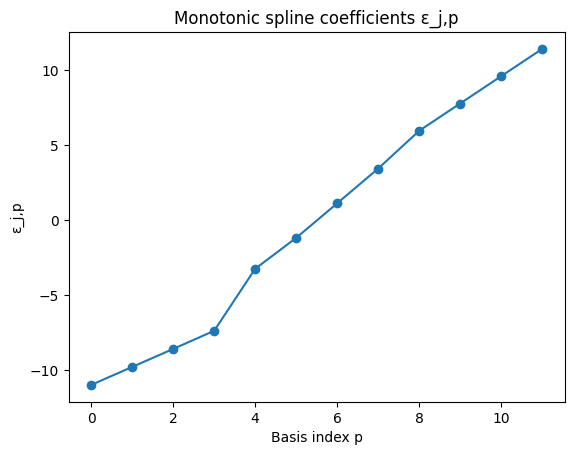

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0000,  -8.1818,  -6.3636,  -4.5455,  -2.7273,  -0.9091,   0.9091,
          2.7273,   4.5455,   6.3636,   8.1818,  10.0000])


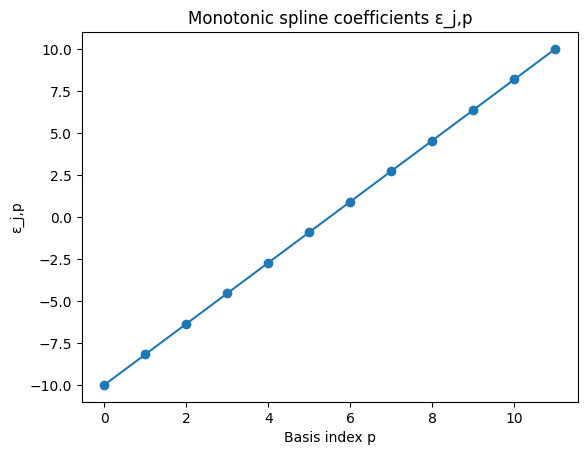

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.7204,  -9.3707,  -8.0211,  -6.6659,  -3.1690,  -1.1515,   1.1534,
          3.3572,   6.4400,   8.2614,  10.0796,  11.8977])


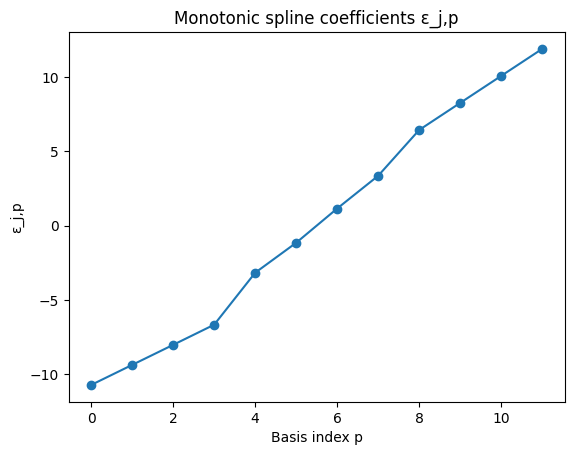

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0000,  -8.1818,  -6.3636,  -4.5455,  -2.7273,  -0.9091,   0.9091,
          2.7273,   4.5455,   6.3636,   8.1818,  10.0000])


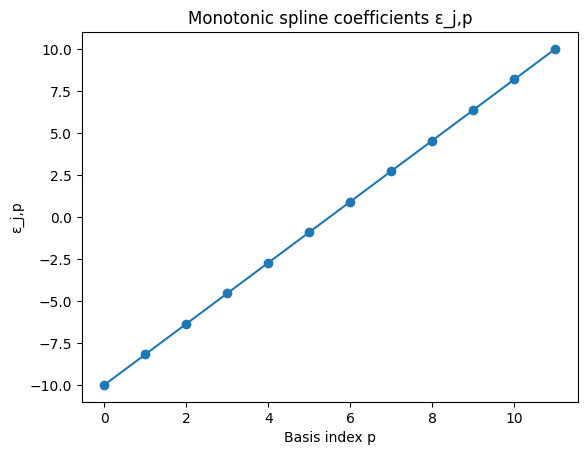

In [11]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

#### PROBLEM HERE, I was trying to introduce a early stop algorithm with the elbo loss, nevertheless, it seems that it overfits wenn i try to use more epochs. I was working with 1000 epoch. 
# It seems, that, it converges but to the wrong state.

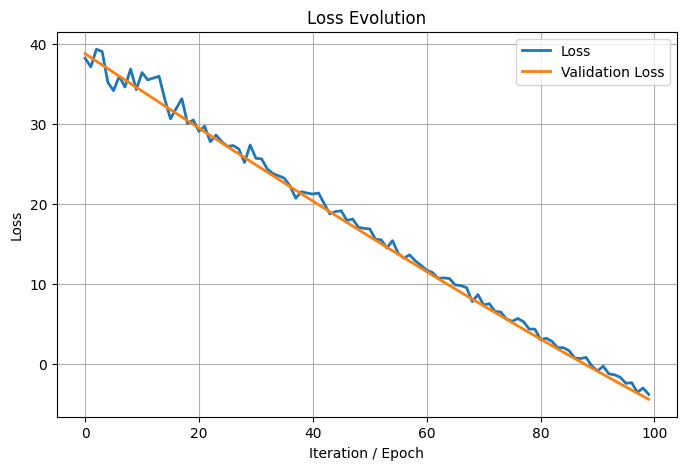

In [24]:
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
output.keys()

dict_keys(['training_time', 'epochs_run', 'best_val', 'loss_history', 'val_history', 'negative_log_likelihood', 'negative_log_prior_decorrelation', 'negative_log_prior_transformation', 'neg_log_posterior_bgtm', 'mu', 'rho', 'vi_model'])

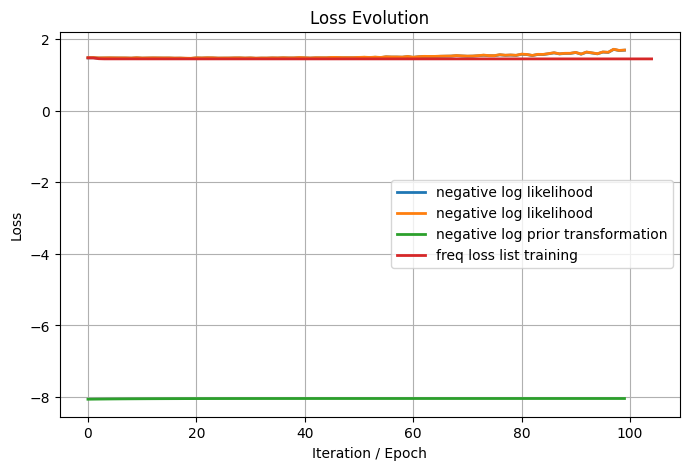

tensor(1.4432, grad_fn=<AddBackward0>)
tensor(1.7133)


In [26]:
neg_log_posterior = output["neg_log_posterior_bgtm"]
neg_log_likelihood = output['negative_log_likelihood']
negative_log_prior_decorrelation = output['negative_log_prior_decorrelation']
negative_log_prior_transformation = output['negative_log_prior_transformation']

##### FREQ #####

loss_list_training = output_freq["loss_list_training"]

# Plot            
plt.figure(figsize=(8, 5))
plt.plot(neg_log_posterior, label="negative log likelihood", linewidth=2)
plt.plot(neg_log_likelihood, label="negative log likelihood", linewidth=2)
#plt.plot(negative_log_prior_decorrelation, label="negative log prior decorrelation", linewidth=2) ZERO 
plt.plot(negative_log_prior_transformation, label="negative log prior transformation", linewidth=2)

plt.plot(loss_list_training, label= "freq loss list training", linewidth=2 )

plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

print(output_freq['loss_with_penalties'])
print(max(neg_log_likelihood))

In [27]:
print(
    "freq_model nr. parameters", sum(p.numel() for p in model_freq.parameters() if p.requires_grad),
    "bay_model nr. parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))

print("VI Model params = ",output['mu'])
print("BGTM params = ",[p for p in model.parameters() if p.requires_grad])
print("GTMp params = ",[p for p in model_freq.parameters() if p.requires_grad])

freq_model nr. parameters 24 bay_model nr. parameters 24
VI Model params =  tensor([-10.0327,   1.5569,   1.5575,   1.5608,   1.5649,   1.8098,   2.1502,
          2.0763,   0.6772,   2.7999,   1.6411,   1.6411, -10.0644,   1.5284,
          1.5297,   1.5269,   1.5413,   1.8313,   2.1191,   1.9957,   1.1799,
          2.6296,   1.6411,   1.6411])
BGTM params =  [Parameter containing:
tensor([-10.0327,   1.5569,   1.5575,   1.5608,   1.5649,   1.8098,   2.1502,
          2.0763,   0.6772,   2.7999,   1.6411,   1.6411], requires_grad=True), Parameter containing:
tensor([-10.0644,   1.5284,   1.5297,   1.5269,   1.5413,   1.8313,   2.1191,
          1.9957,   1.1799,   2.6296,   1.6411,   1.6411], requires_grad=True)]
GTMp params =  [Parameter containing:
tensor([-10.1429,   1.5216,   1.5216,   1.5261,   1.6627,   1.9114,   2.1469,
          1.9855,   0.4524,   1.6577,   1.6411,   1.6411], requires_grad=True), Parameter containing:
tensor([-10.3122,   1.3836,   1.3836,   1.3845,   1.9785,

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [28]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [29]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [30]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.3898
KLD GTM      Train Data:  0.3872
KLD Gaussian Train Data:  0.1177
KLD Copula   Train Data:  -0.0008

KLD BGTM      Test  Data:  0.3731
KLD GTM      Test  Data:  0.3691
KLD Gaussian Test  Data:  0.1092
KLD Copula   Test  Data:  0.0037


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [31]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

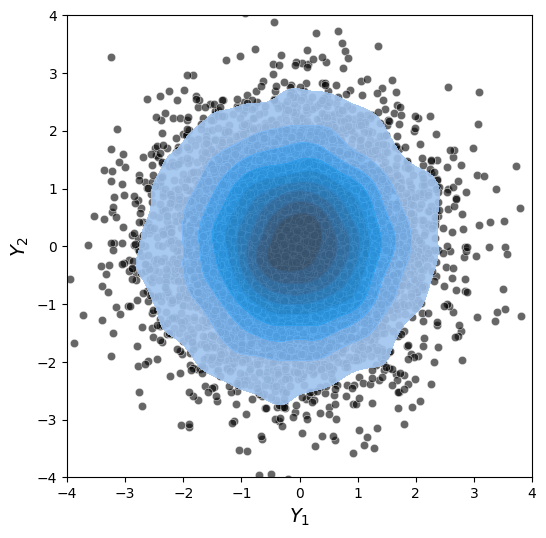

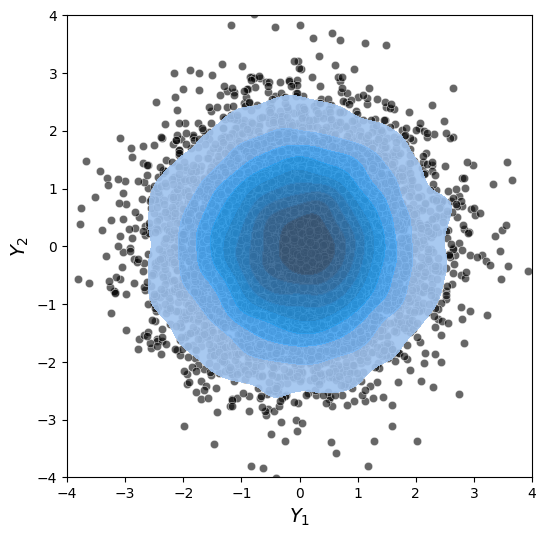

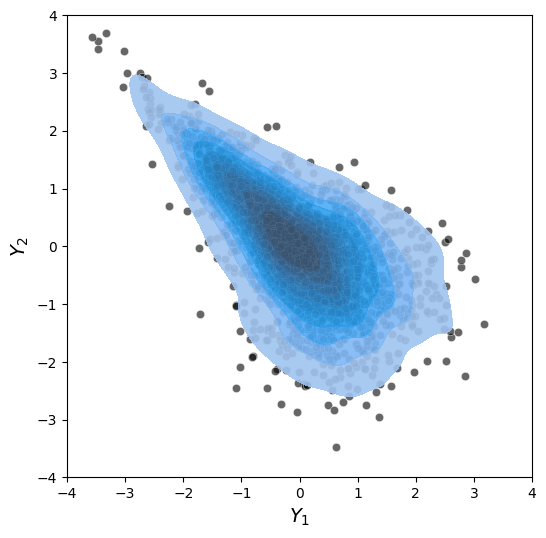

In [32]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [ ]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

: 

: 

In [ ]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

: 

: 

: 

: 

: 

: 

: 

: 

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


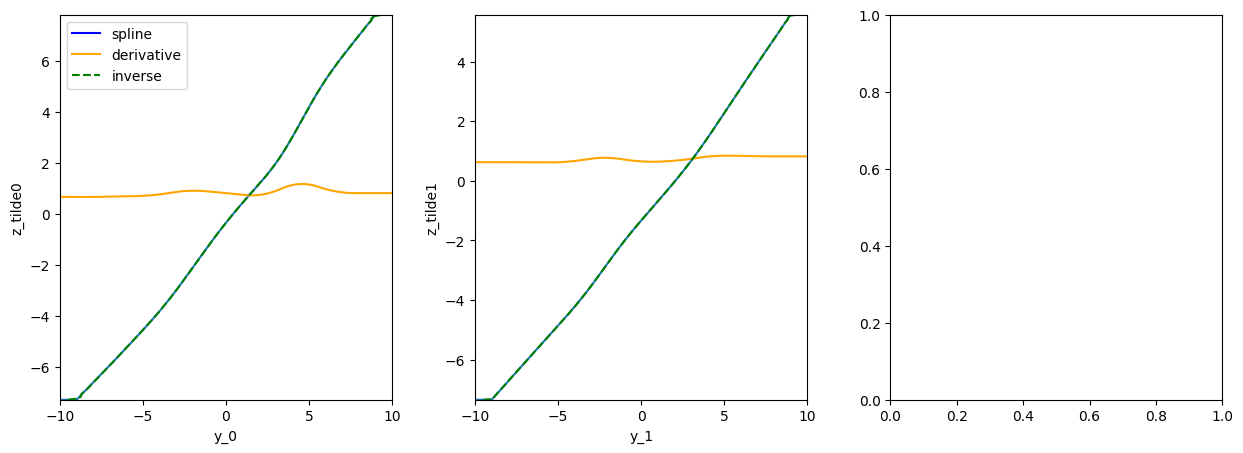

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


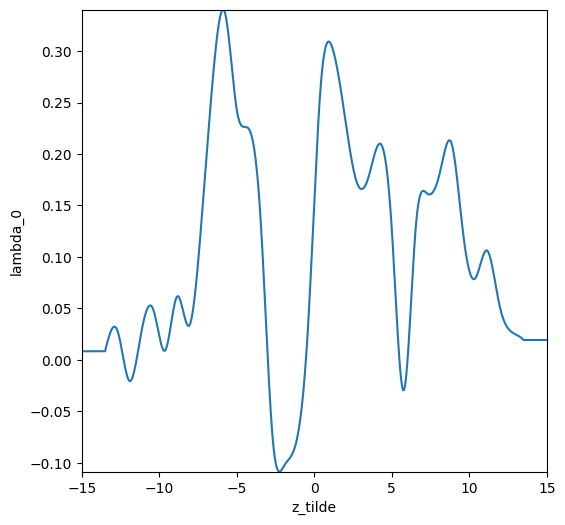

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


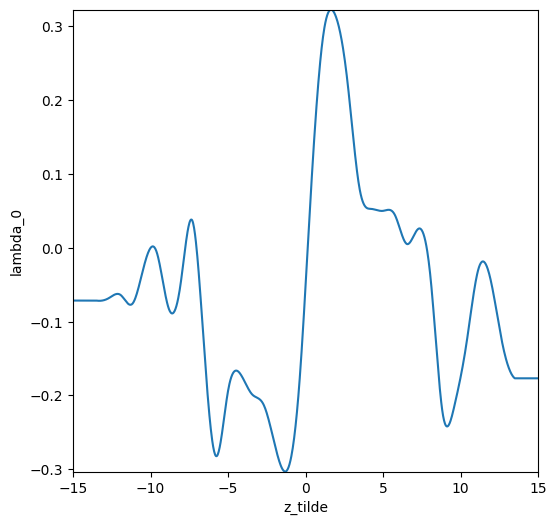

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


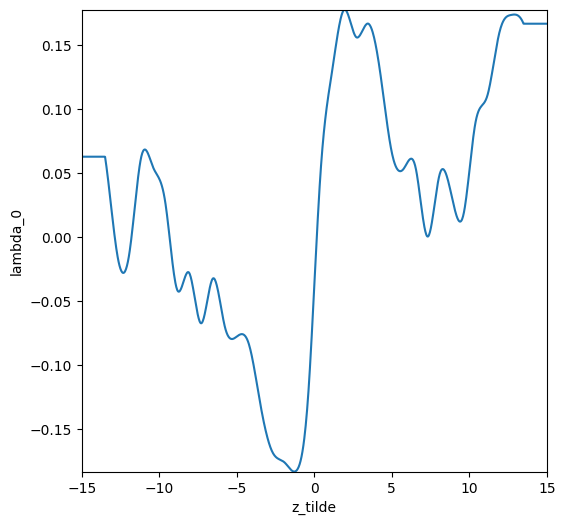

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)